In [52]:
import os

In [53]:
dataset_path = 'C:/pythonn/breast_cancer_data/'

In [54]:
num_benign_images = len(os.listdir(os.path.join(dataset_path, 'BENIGN')))
num_malignant_images = len(os.listdir(os.path.join(dataset_path, 'MALIGNANT')))

In [55]:
print("Number of benign images:", num_benign_images)
print("Number of malignant images:", num_malignant_images)

Number of benign images: 566
Number of malignant images: 494


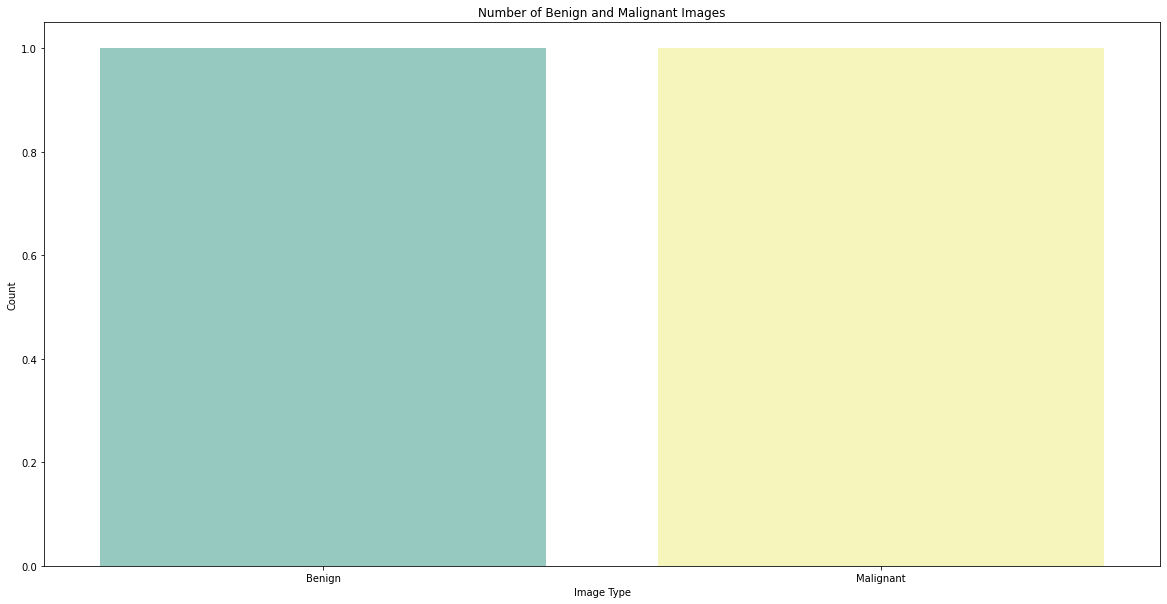

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt


labels = ['Benign', 'Malignant']
counts = [num_benign_images, num_malignant_images]

plt.figure(figsize=(20, 10))
sns.countplot(x=labels)
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of Benign and Malignant Images')

plt.show()

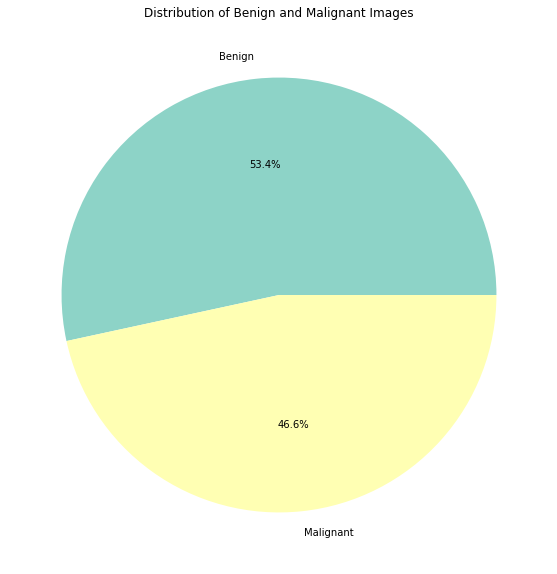

In [57]:
plt.figure(figsize=(10, 10))
sns.set_palette("Set3") 
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Benign and Malignant Images')

plt.show()

In [58]:
benign_path = os.path.join(dataset_path, 'BENIGN')
malignant_path = os.path.join(dataset_path, 'MALIGNANT')

In [59]:
benign_files = os.listdir(benign_path)

In [60]:
import cv2

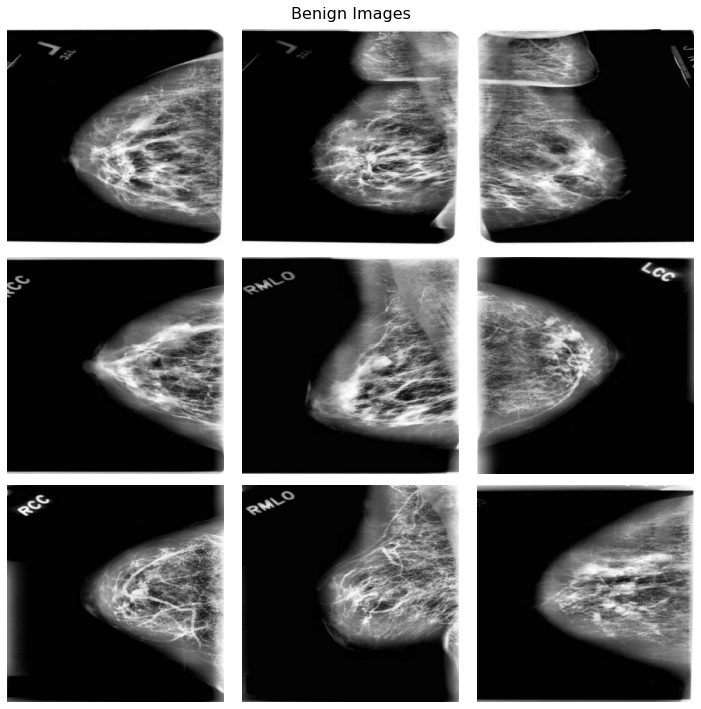

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Benign Images', fontsize=16)
axes = axes.ravel()

for i, image_file in enumerate(benign_files[:9]):
    image_path = os.path.join(benign_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [62]:
malignant_files = os.listdir(malignant_path)

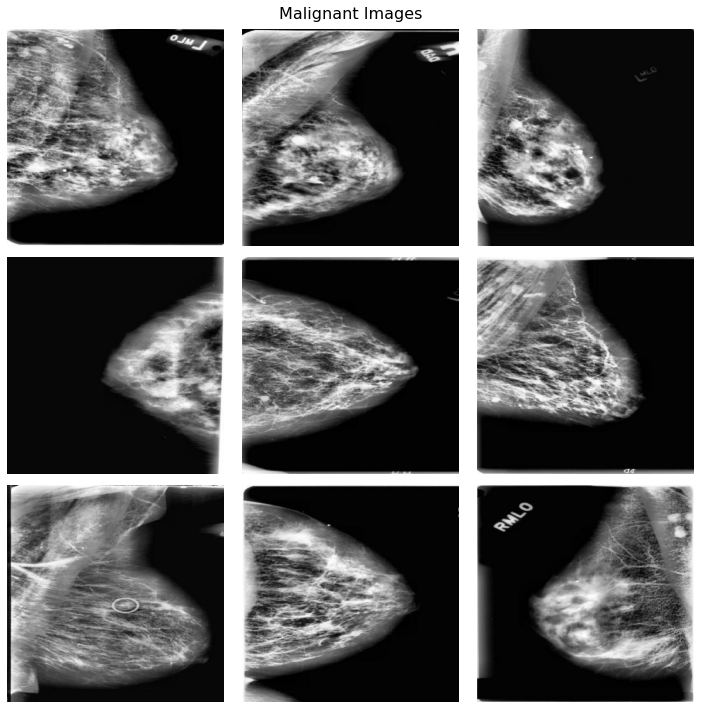

In [63]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Malignant Images', fontsize=16)
axes = axes.ravel()

for i, image_file in enumerate(malignant_files[:9]):
    image_path = os.path.join(malignant_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [87]:
image_shape = (28, 28, 1)
latent_dim = 100

In [88]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.optimizers import Adam

In [89]:
def build_generator():
    model = Sequential()
    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))
    return model

In [90]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=image_shape))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [91]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [92]:
def load_dataset():
    images = []
    classes = ['BENIGN', 'MALIGNANT']
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        image_files = os.listdir(class_path)
        
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"Failed to load image: {image_path}")
                continue
            
            image = cv2.resize(image, image_shape[:2])
            image = image.reshape(image_shape)
            image = image.astype(np.float32) / 255.0
            images.append(image)
    
    images = np.array(images)
    return images

In [93]:
def preprocess_images(images):
    processed_images = []
    for image in images:
        # Resize image to (28, 28)
        resized_image = cv2.resize(image, (28, 28))
        # Normalize image values to [-1, 1]
        normalized_image = resized_image / 255.0 * 2 - 1
        processed_images.append(normalized_image)
    processed_images = np.array(processed_images)
    return processed_images

In [94]:
def generate_fake_samples(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    fake_images = generator.predict(noise)
    # Resize fake images to (28, 28)
    resized_fake_images = []
    for fake_image in fake_images:
        resized_fake_image = cv2.resize(fake_image, (28, 28))
        resized_fake_images.append(resized_fake_image)
    resized_fake_images = np.array(resized_fake_images)
    return resized_fake_images

In [95]:
# Train the GAN
def train_gan(X_train, epochs, batch_size):
    # Build the generator and discriminator models
    generator = build_generator()
    discriminator = build_discriminator()
    
    # Compile the discriminator model
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    # Build the GAN model
    gan = build_gan(generator, discriminator)
    
    # Compile the GAN model
    gan.compile(loss='binary_crossentropy', optimizer=Adam())
    
    # Adversarial ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # Training loop
    for epoch in range(epochs):
        # Train the discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        fake_images = generate_fake_samples(generator, batch_size)
        
        discriminator_loss_real = discriminator.train_on_batch(real_images, real)
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, fake)
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = gan.train_on_batch(noise, real)
        
        # Print the progress
        print(f"Epoch {epoch+1}/{epochs} - Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")
    
    # Save the generator model
    generator.save('generator_model.h5')

In [96]:
images = load_dataset()

preprocessed_images = preprocess_images(images)

epochs = 200
batch_size = 32
train_gan(preprocessed_images, epochs, batch_size)

1/1 [==============================] - 0s 238ms/step
Epoch 1/200 - Discriminator Loss: 0.716308057308197, Generator Loss: 0.6888434290885925
1/1 [==============================] - 0s 79ms/step
Epoch 2/200 - Discriminator Loss: 0.42335034534335136, Generator Loss: 0.6547507047653198
1/1 [==============================] - 0s 94ms/step
Epoch 3/200 - Discriminator Loss: 0.4049183577299118, Generator Loss: 0.5732740759849548
1/1 [==============================] - 0s 79ms/step
Epoch 4/200 - Discriminator Loss: 0.5828907356481068, Generator Loss: 0.6142944693565369
1/1 [==============================] - 0s 95ms/step
Epoch 5/200 - Discriminator Loss: 0.631543526921746, Generator Loss: 0.5057587623596191
1/1 [==============================] - 0s 87ms/step
Epoch 6/200 - Discriminator Loss: 0.7593943801249807, Generator Loss: 0.3324425518512726
1/1 [==============================] - 0s 78ms/step
Epoch 7/200 - Discriminator Loss: 0.9139070881223645, Generator Loss: 0.28877413272857666
1/1 [=======

1/1 [==============================] - 0s 92ms/step
Epoch 59/200 - Discriminator Loss: 0.7196341827511787, Generator Loss: 0.660213828086853
1/1 [==============================] - 0s 94ms/step
Epoch 60/200 - Discriminator Loss: 0.7167409062385559, Generator Loss: 0.6142287254333496
1/1 [==============================] - 0s 110ms/step
Epoch 61/200 - Discriminator Loss: 0.5044263377785683, Generator Loss: 0.7116875648498535
1/1 [==============================] - 0s 95ms/step
Epoch 62/200 - Discriminator Loss: 0.5937357842922211, Generator Loss: 0.762543797492981
1/1 [==============================] - 0s 123ms/step
Epoch 63/200 - Discriminator Loss: 0.569107323884964, Generator Loss: 0.7066041231155396
1/1 [==============================] - 0s 89ms/step
Epoch 64/200 - Discriminator Loss: 0.5568335130810738, Generator Loss: 0.6940820217132568
1/1 [==============================] - 0s 79ms/step
Epoch 65/200 - Discriminator Loss: 0.5707192793488503, Generator Loss: 0.7919795513153076
1/1 [==

1/1 [==============================] - 0s 78ms/step
Epoch 117/200 - Discriminator Loss: 0.3196122944355011, Generator Loss: 1.4642726182937622
1/1 [==============================] - 0s 91ms/step
Epoch 118/200 - Discriminator Loss: 0.3513609319925308, Generator Loss: 1.5018844604492188
1/1 [==============================] - 0s 95ms/step
Epoch 119/200 - Discriminator Loss: 0.38985125720500946, Generator Loss: 1.1828240156173706
1/1 [==============================] - 0s 110ms/step
Epoch 120/200 - Discriminator Loss: 0.46288731321692467, Generator Loss: 1.151862382888794
1/1 [==============================] - 0s 96ms/step
Epoch 121/200 - Discriminator Loss: 0.4680236177518964, Generator Loss: 1.2178666591644287
1/1 [==============================] - 0s 79ms/step
Epoch 122/200 - Discriminator Loss: 0.41314426250755787, Generator Loss: 1.3030527830123901
1/1 [==============================] - 0s 157ms/step
Epoch 123/200 - Discriminator Loss: 0.3479395303875208, Generator Loss: 1.324851036071

1/1 [==============================] - 0s 110ms/step
Epoch 174/200 - Discriminator Loss: 0.23235662747174501, Generator Loss: 2.530421733856201
1/1 [==============================] - 0s 94ms/step
Epoch 175/200 - Discriminator Loss: 0.3153856243006885, Generator Loss: 2.721385955810547
1/1 [==============================] - 0s 94ms/step
Epoch 176/200 - Discriminator Loss: 0.2000516871921718, Generator Loss: 2.9590914249420166
1/1 [==============================] - 0s 79ms/step
Epoch 177/200 - Discriminator Loss: 0.19349268451333046, Generator Loss: 2.7639269828796387
1/1 [==============================] - 0s 84ms/step
Epoch 178/200 - Discriminator Loss: 0.3063471280038357, Generator Loss: 2.3227453231811523
1/1 [==============================] - 0s 135ms/step
Epoch 179/200 - Discriminator Loss: 0.31916634179651737, Generator Loss: 2.1586897373199463
1/1 [==============================] - 0s 94ms/step
Epoch 180/200 - Discriminator Loss: 0.3090458055958152, Generator Loss: 1.9948869943618

1/1 [==============================] - 0s 211ms/step


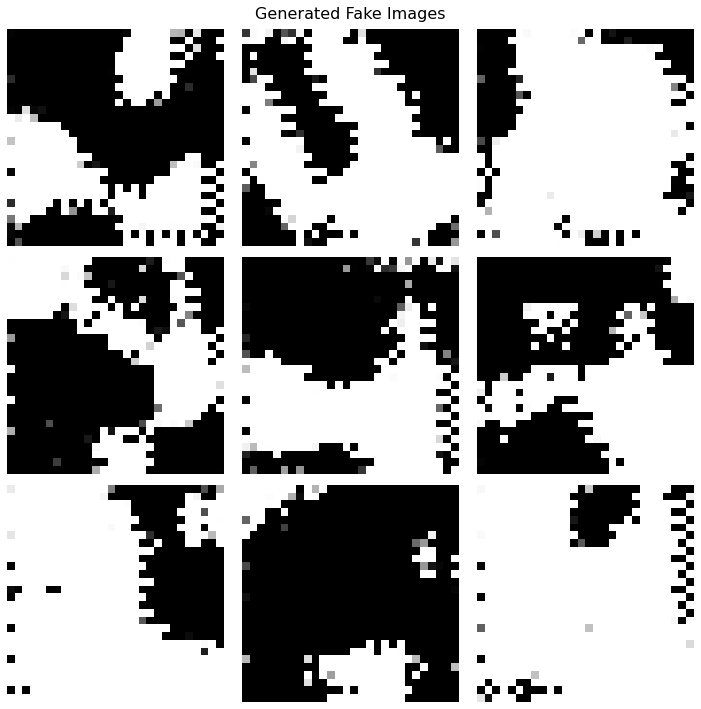

In [97]:
from tensorflow import keras
# Generate fake images using the trained generator
def generate_images(generator, num_images):
    # Generate random noise as input for the generator
    noise = np.random.randn(num_images, 100)
    
    # Generate fake images
    generated_images = generator.predict(noise)
    
    return generated_images

# Load the trained generator model
generator = keras.models.load_model('generator_model.h5')

# Generate and display fake images
num_images = 9
fake_images = generate_images(generator, num_images)

# Rescale pixel values from [-1, 1] to [0, 1]
fake_images = (fake_images + 1) / 2.0

# Create a grid of subplots to display the fake images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Generated Fake Images', fontsize=16)

# Plot each fake image in a subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_images[i], cmap='gray')
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()